Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== 데이터셋 샘플 ===
샘플 1:
텍스트: I love this movie. It's amazing!
입력 토큰 IDs: tensor([ 101, 1045, 2293, 2023, 3185, 1012, 2009, 1005, 1055, 6429,  999,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
어텐션 마스크: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0

c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU})

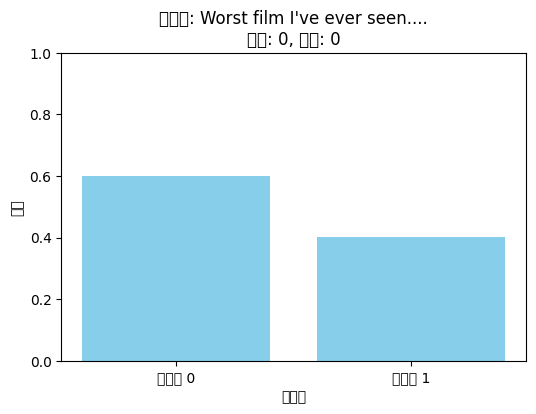

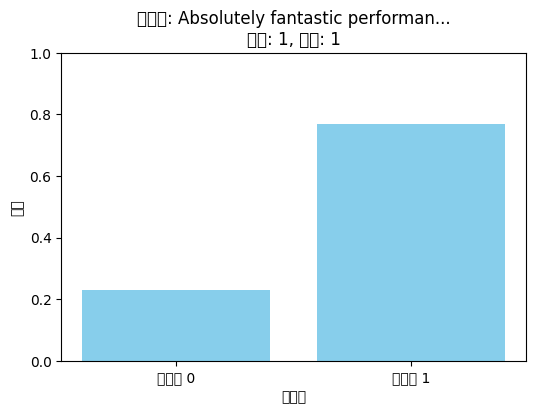

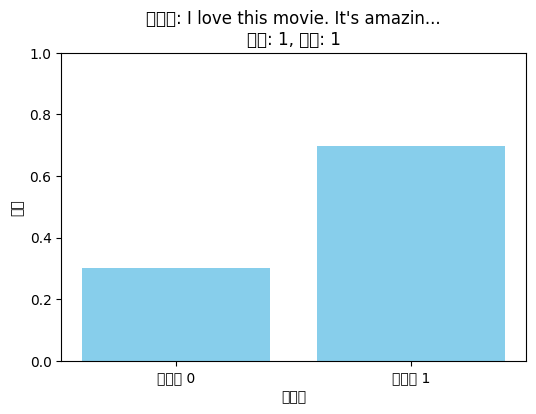

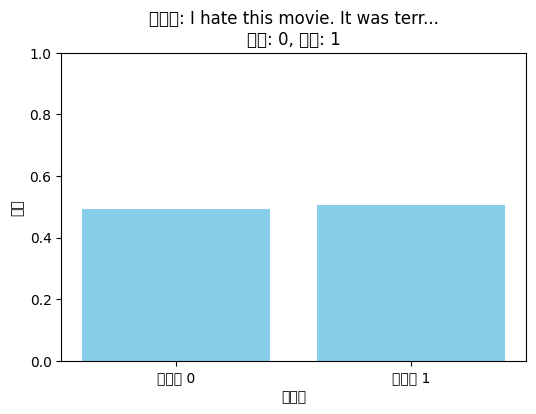

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

"""
Hugging Face의 Transformers 라이브러리를 사용해 BERT 모델을 활용한 감정 분석을 수행
- `BertTokenizer: BERT 모델에 맞게 텍스트를 토큰화하는 도구
- `get_linear_schedule_with_warmup`: 학습률을 조절하는 스케줄러
- `AdamW`: Adam 옵티마이저의 변형으로 가중치 감쇠(weight decay)를 적용하는 옵티마이저
- `BertForSequenceClassification`: 감정 분석 등 분류 작업을 위한 BERT 모델
"""

# 1. 데이터셋 모듈: 텍스트와 레이블을 받아 BERT 입력 형식으로 변환합니다.
class SentimentDataset(Dataset):

    """
    *. __init__(): 데이터셋을 초기화 
    - texts: 입력 텍스트 리스트
    - labels: 각 텍스트에 해당하는 감정 레이블 (예: 긍정/부정)
    - tokenizer: 텍스트를 토큰화할 때 사용할 BERT 토크나이저
    - max_len: 토큰 시퀀스의 최대 길이를 지정

    *. __getitem__(): 주어진 인덱스(idx)에 해당하는 텍스트와 레이블을 가져와 BERT 입력 형식으로 변환
    encoding = tokenizer.encode_plus(
    : 텍스트를 토큰화하고 BERT가 요구하는는 입력 형식에 맞게 변환

    - add_special_tokens=True: [CLS]나 [SEP] 같은 특별 토큰 추가
    - max_length: 최대 길이를 지정하여 길이를 고정
    - padding='max_length': 길이가 부족할 경우 패딩을 추가
    - truncation=True: 너무 길면 자르기
    - return_attention_mask=True: 패딩 부분을 마스킹하는 어텐션 마스크 생성
    - return_tensors='pt': 결과를 PyTorch 텐서로 반환

    *. return 
    딕셔너리 반환
    → 모델 학습에 필요한 입력 데이터(토큰 ID, 어텐션 마스크)와 원본 텍스트, 레이블을 딕셔너리 형태로 반환
    .flatten()은 텐서의 차원을 평평하게 만들어 1차원 배열로 만든다.
    """
    # 클래스 정의 및 초기화
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 샘플 개수 반환
    def __len__(self):
        return len(self.texts)

    #  주어진 인덱스(idx)에 해당하는 텍스트와 레이블을 가져와 BERT 입력 형식으로 변환
    def __getitem__(self, idx):
        text = str(self.texts[idx])# self.texts[idx]가 str일 수도 있지만 혹시 모르니 str로 변환
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. 학습 모듈: 에포크 단위로 모델 학습을 진행합니다.
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

# 3. 평가 모듈: 모델의 정확도를 평가합니다.
def eval_model(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total += labels.size(0)

    return correct_predictions.double() / total

# 4. 데이터셋 샘플 시각화: 데이터셋의 한 두 샘플의 구조를 출력합니다.
def visualize_dataset_sample(dataset, num_samples=3):
    print("=== 데이터셋 샘플 ===")
    for i in range(num_samples):
        sample = dataset[i]
        print(f"샘플 {i+1}:")
        print("텍스트:", sample['text'])
        print("입력 토큰 IDs:", sample['input_ids'])
        print("어텐션 마스크:", sample['attention_mask'])
        print("레이블:", sample['labels'])
        print("-----")

# 5. 모델 결과 시각화 (텍스트 출력): 입력 텍스트와 예측된 결과, 실제 레이블 및 로짓을 출력합니다.
def visualize_model_results(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== 모델 결과 샘플 ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            for j in range(len(batch['text'])):
                print(f"입력 텍스트: {batch['text'][j]}")
                print(f"예측된 레이블: {preds[j].item()}, 실제 레이블: {labels[j].item()}")
                print(f"로짓: {outputs.logits[j].cpu().numpy()}")
                print("-----")

# 6. 모델 결과 시각화 (그래프): Matplotlib을 사용해 각 클래스의 확률을 막대그래프로 출력합니다.
def visualize_model_results_with_plot(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== 모델 결과 시각화 (그래프) ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            for j in range(len(batch['text'])):
                probs = torch.softmax(outputs.logits[j], dim=0).cpu().numpy()
                classes = [f"클래스 {k}" for k in range(len(probs))]
                plt.figure(figsize=(6,4))
                plt.bar(classes, probs, color='skyblue')
                plt.title(f"텍스트: {batch['text'][j][:30]}...\n실제: {labels[j].item()}, 예측: {torch.argmax(outputs.logits[j]).item()}")
                plt.xlabel("클래스")
                plt.ylabel("확률")
                plt.ylim(0, 1)
                plt.show()

# 7. main 함수: 각 모듈을 호출하여 데이터 준비, 모델 학습, 평가, 그리고 시각화를 진행합니다.
def main():
    # 하이퍼파라미터 설정
    PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 토크나이저와 모델 로드
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
    model = model.to(DEVICE)

    # 예제 데이터 (실제 사용 시 대규모 데이터셋 사용 권장)
    texts = [
        "I love this movie. It's amazing!",
        "I hate this movie. It was terrible.",
        "Absolutely fantastic performance.",
        "Worst film I've ever seen."
    ]
    # 1: 긍정, 0: 부정
    labels = [1, 0, 1, 0]

    # 데이터셋 및 DataLoader 생성
    dataset = SentimentDataset(texts, labels, tokenizer, MAX_LEN)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 데이터셋 샘플 시각화
    visualize_dataset_sample(dataset, num_samples=3)

    # 옵티마이저 및 스케줄러 설정
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # 학습 및 평가 루프
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch+1}/{EPOCHS}')
        train_loss = train_epoch(model, data_loader, optimizer, DEVICE, scheduler)
        print(f'Train loss: {train_loss:.4f}')

        accuracy = eval_model(model, data_loader, DEVICE)
        print(f'Accuracy: {accuracy.item()*100:.2f}%')

    # 모델 결과 샘플 시각화 (텍스트 출력)
    visualize_model_results(model, data_loader, DEVICE, num_samples=1)

    # 모델 결과 시각화 (그래프)
    visualize_model_results_with_plot(model, data_loader, DEVICE, num_samples=1)

if __name__ == '__main__':
    main()
